In [13]:
import pandas as pd
import numpy as np

import tubesml as tml

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

import lightgbm as lgb

from source import utility as ut
from source import transform as tr
from source.train import train_model

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings

pd.set_option('max_columns', 100)

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
subs = pd.read_csv('data/sample_submission.csv')

In [4]:
train_set, test_set = ut.make_test(df_train, 0.25, random_state=516, strat_feat='cat9')

train_set.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
217278,362397,A,A,A,A,B,D,A,E,G,F,0.992968,0.062644,0.137455,0.771707,0.494401,0.889793,0.477072,0.777355,0.894772,0.832945,0.528586,0.712178,0.876089,0.594609,6.405349
168076,280139,A,A,A,A,B,A,A,E,A,F,0.706340,0.297613,0.574490,0.685358,0.280016,0.980636,0.875379,0.650188,0.210627,0.543731,0.551951,0.821223,0.898238,0.422612,7.616449
85899,142986,B,B,A,C,B,D,A,E,G,M,0.735604,0.770009,0.350257,0.561776,0.266121,0.918674,0.828429,0.345399,0.901242,0.759109,0.726503,0.637654,0.901267,0.729128,7.678379
66230,110149,A,B,A,C,B,D,A,E,G,I,0.855760,0.617747,0.145037,0.218510,0.677832,0.520412,0.304368,0.676240,0.862597,0.153856,0.177909,0.848022,0.311321,0.766169,6.642889
202344,337370,A,A,A,C,B,B,A,E,C,F,0.397990,0.069838,0.452991,0.174816,0.775703,0.305720,0.349109,0.702810,0.304682,0.441488,0.240995,0.381703,0.302658,0.719237,8.427913


In [5]:
del train_set['id']
del test_set['id']

y = train_set['target'].copy()
del train_set['target']
y_test = test_set['target'].copy()
del test_set['target']

In [6]:
numeric_pipe = Pipeline([('fs', tml.DtypeSel('numeric'))])


cat_pipe = Pipeline([('fs', tml.DtypeSel('category')),
                     ('tarenc', tr.TargetEncoder(to_encode=[f'cat{c}' for c in range(3,10)])),
                     ('dummies', tml.Dummify(match_cols=True, drop_first=True))])


processing_pipe = tml.FeatureUnionDf(transformer_list=[('cat_pipe', cat_pipe),
                                                 ('num_pipe', numeric_pipe)])


full_pipe = Pipeline([('processing', processing_pipe), 
                      ('scaler', tml.DfScaler())])

In [7]:
folds = KFold(10, shuffle=True, random_state=541)

In [8]:
mod = lgb.LGBMRegressor(n_estimators=2000, n_jobs=5)

oof, pred, imp = train_model(train_set, test_set, y, full_pipe, mod, folds, early_stopping=100, verbose=False)

In [17]:
def _plot_diagonal(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    low = min(xmin, xmax)
    high = max(xmin, xmax)
    scl = (high - low) / 100
    
    line = pd.DataFrame({'x': np.arange(low, high ,scl), # small hack for a diagonal line
                         'y': np.arange(low, high ,scl)})
    ax.plot(line.x, line.y, color='black', linestyle='--')
    
    return ax


def plot_regression_predictions(data, true_label, pred_label, hue=None, savename=None):
    '''
    Plot prediction vs true label.
    '''
    
    tmp = data.copy()
    tmp['Prediction'] = pred_label
    tmp['True Label'] = true_label
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    
    legend=False
    addition=''
    if hue is not None:
        if tmp[hue].nunique() > 5:
            warnings.warn(f'{hue} has more than 5 unique values, hue will be ignored', UserWarning)
            hue = None
        else:
            legend=True
            addition = f' by {hue}'

    sns.scatterplot(x='True Label', y='Prediction', data=tmp, ax=ax[0],
                         hue=hue, legend=legend, alpha=0.5)
    
    ax[0] = _plot_diagonal(ax[0])
    ax[0].set_title(f'True Label vs Prediction{addition}', fontsize=14)
        
    sns.histplot(data=tmp, x=true_label, kde=True, ax=ax[1], color='blue', label='True Label', alpha=0.4)
    sns.histplot(data=tmp, x=pred_label, kde=True, ax=ax[1], color='red', label='Prediction', alpha=0.6)
    ax[1].legend()
    ax[1].set_xlabel('Target')
    ax[1].set_title('Distribution of target and prediction', fontsize=14)
    
    if savename is not None:
        plt.savefig('plots/' + savename)
        plt.show()
    else:
        plt.show()

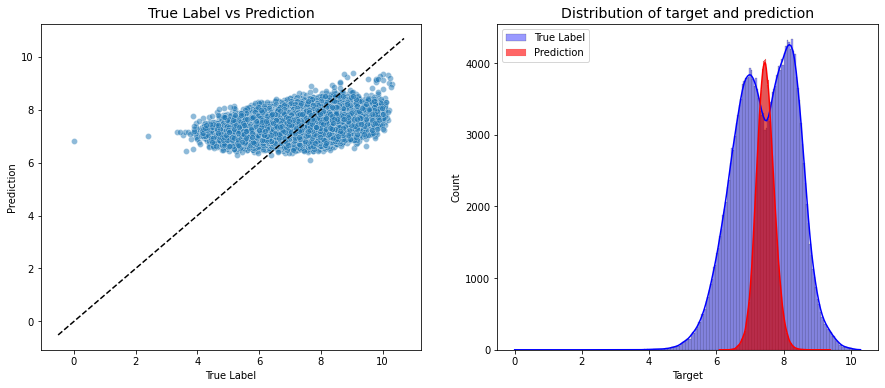

In [18]:
plot_regression_predictions(train_set, y, oof)

<ipython-input-17-d9e1a2324429>:30: UserWarning: cont1 has more than 5 unique values, hue will be ignored
  warnings.warn(f'{hue} has more than 5 unique values, hue will be ignored', UserWarning)


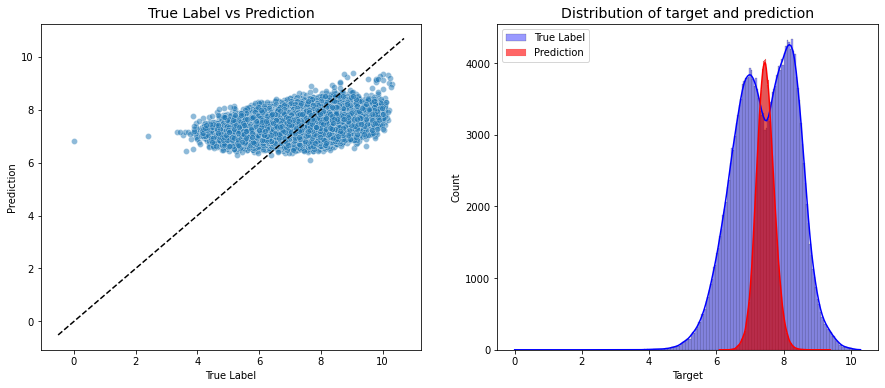

In [19]:
plot_regression_predictions(train_set, y, oof, 'cont1')